$\textbf{Taller 5 Metodos Computacionales 2}$

$\textbf{Punto 1) Monte Carlo y la integral de camino de Feynman}$

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.animation as animation
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams["animation.html"] = "jshtml"


In [36]:

D = 30 
lamb = 670e-7 
A = 0.1 
a = 0.01 
d = 0.09 

N = 10000
z = np.linspace(-0.4, 0.4, 1000)

arr1 = np.zeros(len(z))

def clasica(z):
    theta = np.arctan2(z,D)
    val= (np.cos((np.pi*d/lamb)*np.sin(theta)))**2*(np.sinc((a/lamb)*np.sin(theta)))**2
    return val

for i in range(len(z)):
    arr1[i] = clasica(z[i])
    
arr1 = arr1/np.max(arr1)



def feynman(x,y,z):
    val = np.mean(np.exp(((2* np.pi*1j )/ lamb)* 2*D)*np.exp((np.pi * 1j) / (lamb* D) * (x - y)**2)*np.exp((np.pi * 1j) / (lamb * D) * (z - y)**2))
    return val

arr2 = np.zeros(len(z))

for i in range(len(z)):
    x = np.random.uniform(-A/2, A/2, size=N)
    y = np.random.uniform(d/2, d/2+a, size=N)*np.random.choice([-1,1], N)
    arr2[i] = np.absolute(feynman(x,y,z[i]))*A*a
arr2 = arr2/np.max(arr2)
    


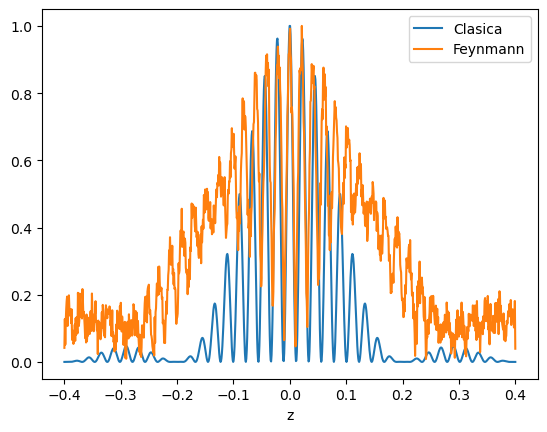

In [35]:
plt.plot(z, arr1,label="Clasica")
plt.plot(z, arr2, label="Feynmann")
plt.xlabel("z")
plt.legend()
plt.show()

In [45]:
import scipy.stats

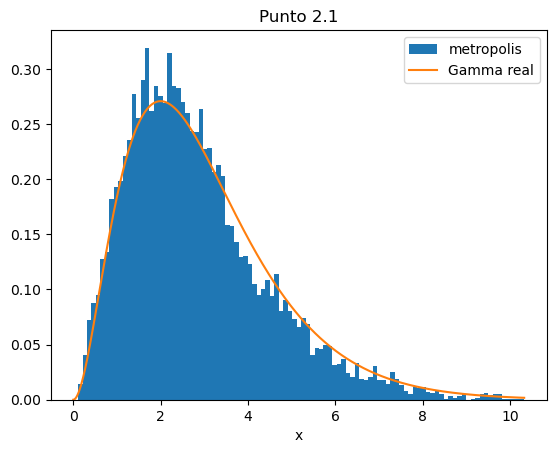

In [46]:
alpha = 3
beta = 1
N = 10000  

def gamma(x, alpha, beta):
    return x**(alpha-1) * np.exp(-x/beta)


def metro_has(alpha, beta, N):
    cadena = np.zeros(N)
    x_init = np.random.rand() 
    for i in range(N):
        x_new = np.random.normal(x_init, 0.5)
        if x_new <= 0:
            cadena[i]=x_init
        else:   
            rata = gamma(x_new, alpha, beta) / gamma(x_init, alpha, beta)
            u = np.random.rand()
            if u < rata:
                x_init = x_new
            
            cadena[i]=x_init
    return cadena


hastings = metro_has(alpha, beta, N)


plt.hist(hastings, bins=100, density=True, label="metropolis")

# Comparar con la distribución Gamma teórica
x = np.linspace(0, max(hastings), 1000)
plt.plot(x, scipy.stats.gamma.pdf(x, a=alpha, scale=beta), label="Gamma real")
plt.title("Punto 2.1")
plt.xlabel('x')
plt.legend()
plt.show()

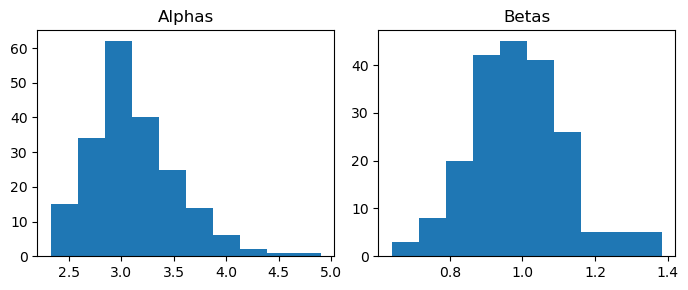

In [49]:
N22=200
recup_alp = np.zeros(N22)
recup_bet = np.zeros(N22)
for i in range(N22):
    muestras = metro_has(alpha, beta, N)
    estad = scipy.stats.gamma.fit(muestras)
    recup_alp[i] = estad[0]
    recup_bet[i] = estad[2] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))
ax1.hist(recup_alp)
ax1.set_title("Alphas")
ax2.hist(recup_bet)
ax2.set_title("Betas")
plt.tight_layout()
plt.show()

In [65]:
@njit
def energia (M,J,n,ite):
    val=0
    for i in range(ite):
        for j in range(n):
            val=+ M[i,j]*(M[np.mod(i+1,n),j]+M[np.mod(i-1,n),j]+M[i,np.mod(j+1,n)]+M[i,np.mod(j-1,n)])
    val=val*(-J)
    return val


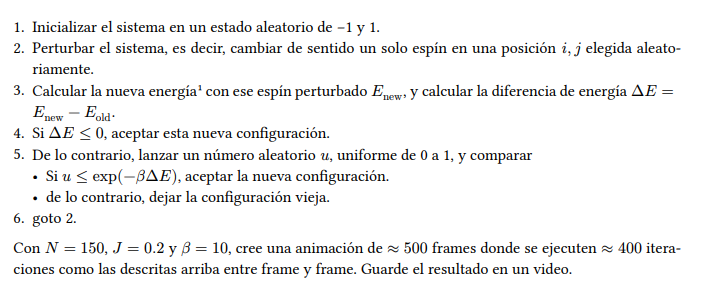

In [106]:
@njit
def evols_por_frames(estruc, M_init, N, beta, J, iteraciones_por_frame, num_frames):
    for s in range(1, num_frames):
        for f in range(iteraciones_por_frame):
            
            ial = np.random.randint(0, N)
            jal = np.random.randint(0, N)
            M_new = M_init.copy()
            M_new[ial, jal] = M_init[ial, jal] * (-1)
            
            E_init = 0
            for i in range(N):
                for j in range(N):
                    E_init += M_init[i, j] * (M_init[np.mod(i+1, N), j] +M_init[np.mod(i-1, N), j] +M_init[i, np.mod(j+1, N)] +M_init[i, np.mod(j-1, N)])
            E_init = E_init * (-J)
            
            
            E_new = 0
            for i in range(N):
                for j in range(N):
                    E_new += M_new[i, j] * (M_new[np.mod(i+1, N), j] +M_new[np.mod(i-1, N), j] +M_new[i, np.mod(j+1, N)] +M_new[i, np.mod(j-1, N)])
            E_new = E_new * (-J)
            
            
            dE = E_new - E_init
            
            
            if dE <= 0:
                M_init = M_new
            else:
                u = np.random.rand()
                if u <= np.exp(-beta * dE):
                    M_init = M_new

        estruc[s] = M_init
    return estruc

In [107]:
N=150
J=0.2
beta=10

num_frames = 500
iteraciones_por_frame = 400


M_init = np.random.choice([-1, 1], size=(N, N))

estructuras = np.zeros((num_frames, N, N))

estructuras[0] = M_init

estructuras = evols_por_frames(estructuras, M_init, N, beta, J, iteraciones_por_frame, num_frames)




In [112]:
import os


def guardar_frames(estructuras, num_frames):
    os.makedirs('frames', exist_ok=True)

    for frame in range(num_frames):
        plt.imshow(estructuras[frame], cmap='coolwarm', vmin=-1, vmax=1)
        plt.axis('off') 
        plt.title(f"Frame {frame + 1}")
        plt.savefig(f'frames/{frame + 1:03d}.png', bbox_inches='tight', pad_inches=0)
        plt.close() 

In [114]:
guardar_frames(estructuras, num_frames)